In [19]:
#!pip install yfinance
#!pip install matplotlib

In [20]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [21]:

# Obtendo os dados históricos das ações da Petrobras
petr4 = yf.Ticker("PETR4.SA")
dados_historicos = petr4.history(period="2y")


In [22]:

# Intervalo de datas dos dados históricos
data_inicio = dados_historicos.index[0].strftime('%Y-%m-%d')
data_fim = dados_historicos.index[-1].strftime('%Y-%m-%d')

In [23]:
# Diretório de trabalho atual
working_dir = Path.cwd()

# Diretório de saída relativo ao diretório de trabalho atual
output_dir = working_dir / 'output'

# Caminho completo para o arquivo 'dados2.xlsx' no diretório de saída
file_path = output_dir / 'dados.xlsx'

# Verifica se o arquivo existe antes de tentar lê-lo
if file_path.exists():
    df_noticias_diarias = pd.read_excel(file_path)
else:
    print("O arquivo 'dados2.xlsx' não foi encontrado.")





In [24]:
# Convertendo a coluna 'data' para datetime
df_noticias_diarias['data'] = pd.to_datetime(df_noticias_diarias['data'], format='%d/%m/%Y %H:%M:%S')

# Formatando a coluna de data para o formato desejado "2023-05-02"
df_noticias_diarias['data'] = df_noticias_diarias['data'].dt.strftime('%Y-%m-%d')


In [25]:
df_noticias_diarias.head()

,data,texto,Link
0,2024-04-26,"Ibovespa tem alta de 1,51% com melhora de Petr...",https://g1.globo.com/economia/noticia/2024/04/...
1,2024-04-26,Por que Petrobras é petroleira que mais paga d...,https://g1.globo.com/economia/negocios/noticia...
2,2024-04-25,Petrobras aprova distribuição de metade dos di...,https://g1.globo.com/jornal-nacional/noticia/2...
3,2024-04-25,"Petrobras aprova R$ 94,3 bilhões em dividendos...",https://g1.globo.com/economia/noticia/2024/04/...
4,2024-04-25,Acionistas da Petrobras aprovam distribuição d...,https://g1.globo.com/politica/blog/valdo-cruz/...


In [26]:
# Convertendo as datas para o formato datetime
dados_historicos.index = pd.to_datetime(dados_historicos.index)
df_noticias_diarias['data'] = pd.to_datetime(df_noticias_diarias['data']).dt.tz_localize('UTC')


In [27]:
# Agrupar as notícias por dia e contar quantas notícias ocorreram em cada dia
df_noticias_diarias['dia'] = df_noticias_diarias['data'].dt.to_period('D')
noticias_por_dia = df_noticias_diarias.groupby('dia').size().reset_index(name='quantidade_noticias')


C:\Users\felip\AppData\Local\Temp\ipykernel_2124\1520819624.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_noticias_diarias['dia'] = df_noticias_diarias['data'].dt.to_period('D')


In [28]:
# Renomear a coluna de data para facilitar a mesclagem
dados_historicos = dados_historicos.rename_axis('data').reset_index()

# Mesclar os dados históricos com a contagem de notícias por dia
dados_mesclados_diarios = pd.merge(dados_historicos, noticias_por_dia, left_on=dados_historicos['data'].dt.to_period('D'), right_on='dia', how='left')

# Calcular a variação percentual em relação ao dia anterior
dados_mesclados_diarios['Variacao'] = dados_mesclados_diarios['Close'].pct_change() * 100

# Definir o critério para mudanças significativas (por exemplo, 5%)
limite = 5

# Identificar os pontos onde a variação é maior que o limite
mudancas_significativas = dados_mesclados_diarios[abs(dados_mesclados_diarios['Variacao']) > limite]


C:\Users\felip\AppData\Local\Temp\ipykernel_2124\2545831139.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dados_mesclados_diarios = pd.merge(dados_historicos, noticias_por_dia, left_on=dados_historicos['data'].dt.to_period('D'), right_on='dia', how='left')


##MONTANDO O GRAFICO

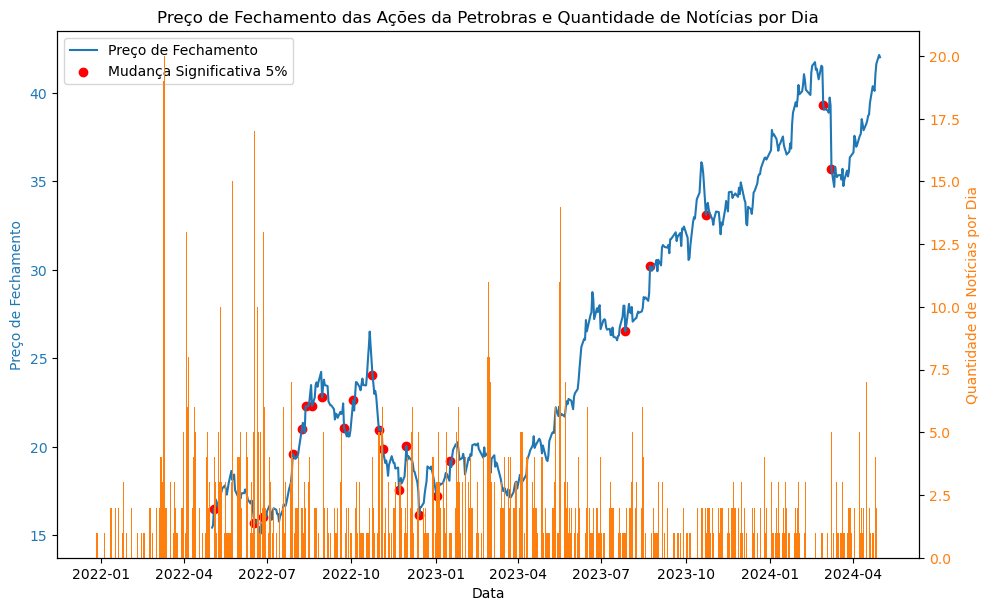

In [29]:

# Plotar o preço de fechamento das ações da Petrobras
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço de Fechamento', color=color)
ax1.plot(dados_mesclados_diarios['data'], dados_mesclados_diarios['Close'], label='Preço de Fechamento', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Adicionar os pontos de mudança significativa
ax1.scatter(mudancas_significativas['data'], mudancas_significativas['Close'], color='red', marker='o', label=f'Mudança Significativa {limite}%')
ax1.legend(loc='upper left')

# Plotar a quantidade de notícias por dia
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Quantidade de Notícias por Dia', color=color)
ax2.bar(noticias_por_dia['dia'].dt.to_timestamp(), noticias_por_dia['quantidade_noticias'], color=color, label='Quantidade de Notícias por Dia')
ax2.tick_params(axis='y', labelcolor=color)

# Adicionar rótulo e legendas
fig.tight_layout()  
plt.title('Preço de Fechamento das Ações da Petrobras e Quantidade de Notícias por Dia')
plt.show()

In [30]:
# Listar as possíveis notícias que podem ter impactado na mudança significativa
for index, ponto_mudanca in mudancas_significativas.iterrows():
    data_mudanca = ponto_mudanca['data'].strftime('%d/%m/%Y')
    dias_antes = 5
    print(f"Notícias de {dias_antes} dias antes que podem ter impactado na mudança significativa na data {data_mudanca}:")
    
    # Filtrar as notícias dos cinco dias anteriores ao ponto de mudança significativa
  
    data_mudanca = ponto_mudanca['data']
    data_inicio = data_mudanca - pd.Timedelta(days=dias_antes)
    data_fim = data_mudanca - pd.Timedelta(days=1)
    noticias = df_noticias_diarias[(df_noticias_diarias['data'] >= data_inicio) & (df_noticias_diarias['data'] <= data_fim)]
    
    # Lista de notícias afetadas para esta mudança significativa
    noticias_afetadas = noticias['texto'].tolist()
    
    # Imprimir as notícias afetadas
    for noticia in noticias_afetadas:
        print("-", noticia)
    
    print()


Notícias de 5 dias antes que podem ter impactado na mudança significativa na data 04/05/2022:
- Nova unidade da Replan terá investimento de US$ 458 milhões e prevê 3 mil empregos em Paulínia
- Alta de 19% no gás natural da Petrobras para distribuidoras já está em vigor

Notícias de 5 dias antes que podem ter impactado na mudança significativa na data 17/06/2022:
- Lira cobra saída do presidente da Petrobras e diz que vai discutir mudança na política de preços na segunda-feira
- Ala política do governo e aliados declaram guerra à Petrobras e tentam reverter reajuste de preços
- Conselho de Administração da Petrobras dá sinal verde para aumento de combustível
- Conselho de Administração da Petrobras é convocado para discutir preços nesta quinta
- Postos de Natal aumentam preço do litro de gasolina para até R$ 7,99
- Ibovespa quebra sequência de oito quedas e fecha em alta
- 'Teto' do ICMS para combustíveis: entenda o que pode mudar para o consumidor
- Em reunião com diretoria da Petrobra